In [ ]:
import os
import shutil
from matplotlib import pyplot as plt
from ipywidgets import Button, HBox, VBox, Label
from IPython.display import display, clear_output


In [ ]:
def list_images_and_csvs(directory):
    supported_extensions = ['.png']
    image_csv_map = {}
    for root, dirs, files_in_dir in os.walk(directory):
        for file in files_in_dir:
            if any(file.endswith(ext) for ext in supported_extensions):
                full_image_path = os.path.join(root, file)
                # Assuming CSV is in a parallel 'Parameters' directory with the same file stem
                csv_path = full_image_path.replace('/Images/', '/Parameters/').replace(file[-3:], 'csv')
                image_csv_map[full_image_path] = csv_path
    return image_csv_map


In [ ]:
import os
import shutil
from IPython.display import display, clear_output
from ipywidgets import Button, HBox, VBox, Output
from matplotlib import pyplot as plt

def manually_select_files(image_csv_map):
    selected_files = []
    output = Output()

    def on_button_clicked(b):
        clear_output(wait=True)
        if b.description == 'Select':
            selected_files.append((b.image_path, b.csv_path))
            print(f"Selected: {os.path.basename(b.image_path)}")
        display_next_image()

    def display_next_image():
        try:
            image_path, csv_path = next(image_iter)
            img = plt.imread(image_path)
            plt.figure(figsize=(12, 10))  # Increase image display size
            plt.imshow(img)
            plt.axis('off')
            plt.title(os.path.basename(image_path))
            plt.show()

            button_select = Button(description="Select", button_style='success')
            button_skip = Button(description="Skip", button_style='danger')

            button_select.image_path = image_path
            button_select.csv_path = csv_path
            button_select.on_click(on_button_clicked)

            button_skip.image_path = image_path
            button_skip.csv_path = csv_path
            button_skip.on_click(on_button_clicked)

            display(HBox([button_select, button_skip]), output)
        except StopIteration:
            print("No more images to display.")

    image_iter = iter(image_csv_map.items())
    display_next_image()
    return selected_files


In [ ]:
def copy_files(files, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for image_path, csv_path in files:
        shutil.copy(image_path, os.path.join(target_dir, os.path.basename(image_path)))
        shutil.copy(csv_path, os.path.join(target_dir, os.path.basename(csv_path)))
        print(f"Copied {image_path} and {csv_path} to {target_dir}")


In [ ]:
def main():
    source_dir = '/home/mzo5929/Keerthana/MoiseEtAl/extractedData/parameterResults/'
    target_dir = '/home/mzo5929/Keerthana/MoiseEtAl/extractedData/selectedImages'

    image_csv_map = list_images_and_csvs(source_dir)
    selected_files = manually_select_files(image_csv_map)
    copy_files(selected_files, target_dir)

if __name__ == '__main__':
    main()

In [7]:
import os
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import threading
import queue

class ImageViewer(tk.Tk):
    def __init__(self, image_folder, cache_size=10):
        super().__init__()
        self.title('Image Viewer')
        self.image_folder = image_folder
        self.image_paths = self.collect_image_paths()
        self.image_index = 0
        self.cache_size = cache_size
        self.image_cache = queue.Queue(maxsize=self.cache_size)
        self.image_label = tk.Label(self)
        self.image_label.pack()

        self.bind('<Right>', self.next_image)
        self.bind('<Left>', self.previous_image)

        self.preload_images()
        self.update_image()

    def collect_image_paths(self):
        supported_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp']
        image_paths = []
        for root, dirs, files in os.walk(self.image_folder):
            for file in files:
                if any(file.endswith(ext) for ext in supported_extensions):
                    full_path = os.path.join(root, file)
                    image_paths.append(full_path)
        return image_paths

    def preload_images(self):
        def load():
            for i in range(self.image_index, min(self.image_index + self.cache_size, len(self.image_paths))):
                if not self.image_cache.full():
                    image_path = self.image_paths[i]
                    img = Image.open(image_path)
                    img.thumbnail((800, 600), Image.ANTIALIAS)
                    photo = ImageTk.PhotoImage(img)
                    self.image_cache.put((image_path, photo))
        threading.Thread(target=load).start()

    def update_image(self):
        if not self.image_cache.empty():
            image_path, photo = self.image_cache.get()
            self.image_label.config(image=photo)
            self.image_label.image = photo  # Keep a reference!
            self.title(f'Viewing {os.path.basename(image_path)}')
        else:
            messagebox.showinfo("End", "No more images to display.")
            self.destroy()  # Close the application

    def next_image(self, event):
        if self.image_index < len(self.image_paths) - 1:
            self.image_index += 1
            if self.image_cache.empty():
                self.preload_images()
            self.update_image()

    def previous_image(self, event):
        if self.image_index > 0:
            self.image_index -= 1
            self.update_image()

if __name__ == '__main__':
    root_folder = filedialog.askdirectory(title='Select Image Folder')
    if root_folder:
        app = ImageViewer(root_folder)
        app.mainloop()


TclError: no display name and no $DISPLAY environment variable

In [14]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import os
from PIL import Image
import shutil
import queue
from threading import Thread


In [17]:
def get_image_files(directory):
    extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.endswith(ext) for ext in extensions):
                image_files.append(os.path.join(root, file))
    return image_files

def preload_images(image_files, cache_size=5):
    q = queue.Queue(maxsize=cache_size)
    def loader():
        for file_path in image_files:
            img = Image.open(file_path)
            img.thumbnail((800, 600))
            q.put(img)
    Thread(target=loader, daemon=True).start()
    return q


In [20]:
def image_reviewer(directory, target_dir):
    image_files = get_image_files(directory)
    cache = preload_images(image_files)
    selected_files = []
    index = 0

    def display_next_image():
        if not cache.empty():
            img = cache.get()
            clear_output(wait=True)
            display(img)
        else:
            print("Loading next images... Please wait.")

    display_next_image()

    def handle_key_event(event):
        nonlocal index
        if event.key == 'right':
            index += 1 if index < len(image_files) - 1 else 0
        elif event.key == 'left':
            index -= 1 if index > 0 else 0
        elif event.key == 's':
            selected_files.append(image_files[index])
            print(f"Selected: {os.path.basename(image_files[index])}")
        elif event.key == 'c':
            copy_selected_files()

        display_next_image()

    def copy_selected_files():
        os.makedirs(target_dir, exist_ok=True)
        for file_path in selected_files:
            shutil.copy(file_path, os.path.join(target_dir, os.path.basename(file_path)))
        print(f"Copied {len(selected_files)} files to {target_dir}")

    widgets.interact(handle_key_event, event=widgets.Text())


In [21]:
def main():
    source_dir = '/home/mzo5929/Keerthana/MoiseEtAl/extractedData/parameterResults/'
    target_dir = '/home/mzo5929/Keerthana/MoiseEtAl/extractedData/selectedImages'

    image_reviewer(source_dir, target_dir)

if __name__ == '__main__':
    main()


Loading next images... Please wait.


interactive(children=(Text(value='', description='event'), Output()), _dom_classes=('widget-interact',))

In [13]:
def main():
    source_dir = '/home/mzo5929/Keerthana/MoiseEtAl/extractedData/parameterResults/'
    target_dir = '/home/mzo5929/Keerthana/MoiseEtAl/extractedData/selectedImages'

    image_reviewer(source_dir, target_dir)

if __name__ == '__main__':
    main()


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x0b\xb8\x00\x00\x07\x08\x08\x06\x00\x00\x00\xac\x7f\…

Button(description='Next', style=ButtonStyle())

Button(description='Select This Image', style=ButtonStyle())

Output()

Button(description='Copy Selected Files', style=ButtonStyle())

In [1]:
import os
import shutil
from IPython.display import display, clear_output
from PIL import Image
import queue
from threading import Thread

class ImageReviewer:
    def __init__(self, directory, target_directory, cache_size=5):
        self.directory = directory
        self.target_directory = target_directory
        self.image_files = get_image_files(directory)
        self.cache = preload_images(self.image_files, cache_size)
        self.index = 0
        self.selected_files = []

    def show_image(self):
        clear_output(wait=True)  # Clear the previous image/text output
        if not self.cache.empty():
            file_path, img = self.cache.get()
            display(img)  # Display the current image
            print(f"Displaying: {os.path.basename(file_path)} - Use ArrowRight, ArrowLeft, 's' to select, 'c' to copy")
        else:
            print("Loading next images... Please wait.")

    def next_image(self):
        if self.index < len(self.image_files) - 1:
            self.index += 1
            self.show_image()

    def previous_image(self):
        if self.index > 0:
            self.index -= 1
            self.show_image()

    def select_image(self):
        if self.image_files[self.index] not in self.selected_files:
            self.selected_files.append(self.image_files[self.index])
            print(f"Selected: {os.path.basename(self.image_files[self.index])}")

    def copy_selected_files(self):
        for file_path in self.selected_files:
            relative_path = os.path.relpath(file_path, self.directory)
            target_path = os.path.join(self.target_directory, relative_path)
            os.makedirs(os.path.dirname(target_path), exist_ok=True)
            shutil.copy(file_path, target_path)
        print(f"Copied {len(self.selected_files)} files to {self.target_directory}")

# Helper functions for getting image files and preloading images
def get_image_files(directory):
    extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return [os.path.join(root, file)
            for root, dirs, files in os.walk(directory)
            for file in files if any(file.endswith(ext) for ext in extensions)]

def preload_images(image_files, cache_size=5):
    q = queue.Queue(maxsize=cache_size)
    def loader():
        for file_path in image_files:
            img = Image.open(file_path)
            img.thumbnail((800, 600), Image.Resampling.LANCZOS)  # Update here
            q.put((file_path, img))
    Thread(target=loader, daemon=True).start()
    return q


In [4]:
source_dir = '/home/mzo5929/Keerthana/MoiseEtAl/extractedData/parameterResults/'
target_dir = '/home/mzo5929/Keerthana/MoiseEtAl/extractedData/selectedImages/'
reviewer = ImageReviewer(source_dir, target_dir)


In [2]:
from IPython.display import display, Javascript

def disable_keyboard_manager():
    js_code = """
    Jupyter.keyboard_manager.disable();
    """
    display(Javascript(js_code))

disable_keyboard_manager()


<IPython.core.display.Javascript object>

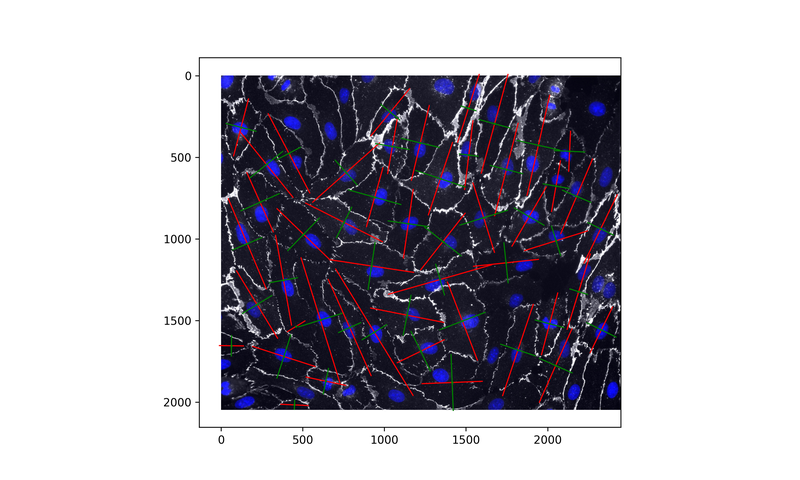

Displaying: 2024_03_29_wmj_cont_static_20x_0001_zoverlay_seg.png - Use ArrowRight, ArrowLeft, 's' to select, 'c' to copy


In [5]:
reviewer.show_image()

In [3]:
def setup_keyboard_listeners():
    js_code = """
    document.addEventListener('keydown', function(event) {
        if (['ArrowRight', 'ArrowLeft', 's', 'c'].includes(event.key)) {
            event.preventDefault();  // Prevent default actions
            event.stopPropagation(); // Stop the event from propagating
            var kernel = IPython.notebook.kernel;
            if(event.key === 'ArrowRight') {
                kernel.execute('reviewer.next_image()');
            } else if(event.key === 'ArrowLeft') {
                kernel.execute('reviewer.previous_image()');
            } else if(event.key === 's') {
                kernel.execute('reviewer.select_image()');
            } else if(event.key === 'c') {
                kernel.execute('reviewer.copy_selected_files()');
            }
        }
    }, true);  // Use capture phase for handling events
    """
    display(Javascript(js_code))

setup_keyboard_listeners()


<IPython.core.display.Javascript object>